In [1]:
## general
import numpy as np
import datetime
from sklearn.externals import joblib
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm


## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from scipy.optimize import curve_fit

# statistics which aren't all that nice in python
import rpy2.robjects as robjects

## my stuff
sys.path.insert(1,'/home/snath/polybox/LAMACLIMA/')
from tools.loading import load_data_single_mod
from tools.processing import AR1_predict, compute_llh_cv,gaspari_cohn
from tools.plotting import TaylorDiagram


## plotting
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs

##for parallelisation
from sklearn.externals.joblib import Parallel, delayed

/home/snath/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error: package or namespace load failed for ‘RevoUtilsMath’:
 .onLoad failed in loadNamespace() for 'RevoUtilsMath', details:
  call: NULL
  error: Remove Microsoft R and then re-install.
Be sure to select MKL libraries as an install option.

  warnings.warn(x, RRuntimeWarning)
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/snath/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
##training for cmip6 models
dir_data = '/net/so4/landclim/snath/data/cmip6-ng/train_test_split_final/'

models = ['ACCESS-CM2','ACCESS-ESM1-5','AWI-CM-1-1-MR','BCC-CSM2-MR','CAMS-CSM1-0','CESM2-WACCM','CESM2','CIESM','CMCC-CM2-SR5','CNRM-CM6-1-HR','CNRM-CM6-1','CNRM-ESM2-1',
          'CanESM5','EC-Earth3-Veg','EC-Earth3','FGOALS-f3-L','FGOALS-g3','FIO-ESM-2-0','GFDL-CM4','GFDL-ESM4','HadGEM3-GC31-LL','HadGEM3-GC31-MM',
         'INM-CM4-8','INM-CM5-0','IPSL-CM6A-LR','KACE-1-0-G','KIOST-ESM','MCM-UA-1-0','MIROC-ES2L','MIROC6','MPI-ESM1-2-HR',
         'MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','NorESM2-LM','NorESM2-MM','TaiESM1','UKESM1-0-LL']#CanESM5-CanOE,'IPSL-CM6A-LR'


#models=['IPSL-CM6A-LR','MIROC6','MRI-ESM2-0','NorESM2-LM','NorESM2-MM']
run_nrs={}
run_nrs['ACCESS-CM2']=[1,2]
run_nrs['ACCESS-ESM1-5']=[1,2,3,4,5,6,7]
run_nrs['AWI-CM-1-1-MR']=[1]
run_nrs['BCC-CSM2-MR']=[1]
run_nrs['CAMS-CSM1-0']=[1]
run_nrs['CESM2-WACCM']=[1,2]
run_nrs['CESM2']=[1,2,4]
run_nrs['CIESM']=[1]
run_nrs['CMCC-CM2-SR5']=[1]
run_nrs['CNRM-CM6-1-HR']=[1]
run_nrs['CNRM-CM6-1']=[1,2,3,4]
run_nrs['CNRM-ESM2-1']=[1,2,3]
run_nrs['CanESM5-CanOE']=[1,2]
run_nrs['CanESM5']=[1,2,3,4,5,6,7,8,9,10,11,12,13]
run_nrs['EC-Earth3-Veg']=[1,2,3]
run_nrs['EC-Earth3']=[1,4,6,9]
run_nrs['FGOALS-f3-L']=[1]
run_nrs['FGOALS-g3']=[1,2]
run_nrs['FIO-ESM-2-0']=[1,2]
run_nrs['GFDL-CM4']=[1]
run_nrs['GFDL-ESM4']=[1]
run_nrs['HadGEM3-GC31-LL']=[1,2]
run_nrs['HadGEM3-GC31-MM']=[1,2]
run_nrs['INM-CM4-8']=[1]
run_nrs['INM-CM5-0']=[1]
run_nrs['IPSL-CM6A-LR']=[1,2,3,4]
run_nrs['KACE-1-0-G']=[1,2]
run_nrs['KIOST-ESM']=[1]
run_nrs['MCM-UA-1-0']=[1]
run_nrs['MIROC-ES2L']=[1]
run_nrs['MIROC6']=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,
                   17,18,19,20,21,22,23,24,25]
run_nrs['MPI-ESM1-2-HR']=[1]
run_nrs['MPI-ESM1-2-LR']=[1,2,3,4,5,6,7]
run_nrs['MRI-ESM2-0']=[1]
run_nrs['NESM3']=[1]
run_nrs['NorESM2-LM']=[1]
run_nrs['NorESM2-MM']=[1]
run_nrs['TaiESM1']=[1]
run_nrs['UKESM1-0-LL']=[1,2,3]

test_run_nrs={}
test_run_nrs['ACCESS-CM2']=[3]
test_run_nrs['ACCESS-ESM1-5']=[8,9,10]
test_run_nrs['AWI-CM-1-1-MR']=[1]
test_run_nrs['BCC-CSM2-MR']=[1]
test_run_nrs['CAMS-CSM1-0']=[2]
test_run_nrs['CESM2-WACCM']=[3]
test_run_nrs['CESM2']=[10,11]
test_run_nrs['CIESM']=[1]
test_run_nrs['CMCC-CM2-SR5']=[1]
test_run_nrs['CNRM-CM6-1-HR']=[1]
test_run_nrs['CNRM-CM6-1']=[5,6]
test_run_nrs['CNRM-ESM2-1']=[4,5]
test_run_nrs['CanESM5-CanOE']=[3]
test_run_nrs['CanESM5']=[14,15,16,17,18,19,20,21,22,23,24,25]
test_run_nrs['EC-Earth3-Veg']=[4,6]
test_run_nrs['EC-Earth3']=[11,13,15]
test_run_nrs['FGOALS-f3-L']=[1]
test_run_nrs['FGOALS-g3']=[3,4]
test_run_nrs['FIO-ESM-2-0']=[3]
test_run_nrs['GFDL-CM4']=[1]
test_run_nrs['GFDL-ESM4']=[1]
test_run_nrs['HadGEM3-GC31-LL']=[3,4]
test_run_nrs['HadGEM3-GC31-MM']=[3]
test_run_nrs['INM-CM4-8']=[1]
test_run_nrs['INM-CM5-0']=[1]
test_run_nrs['IPSL-CM6A-LR']=[6,14]
test_run_nrs['KACE-1-0-G']=[3]
test_run_nrs['KIOST-ESM']=[1]
test_run_nrs['MCM-UA-1-0']=[1]
test_run_nrs['MIROC-ES2L']=[1]
test_run_nrs['MIROC6']=[26,27,28,29,30,
                   31,32,33,34,35,36,37,38,39,40,
                        41,42,43,44,45,46,47,48,49,50]
test_run_nrs['MPI-ESM1-2-HR']=[2]
test_run_nrs['MPI-ESM1-2-LR']=[8,9,10]
test_run_nrs['MRI-ESM2-0']=[1]
test_run_nrs['NESM3']=[2]
test_run_nrs['NorESM2-LM']=[1]
test_run_nrs['NorESM2-MM']=[1]
test_run_nrs['TaiESM1']=[1]
test_run_nrs['UKESM1-0-LL']=[4,8]


In [3]:
## extract cmip5 models' results

##Extract test and train results

train_results_all={}
test_results_all={}

Tanglob_wgt={}
y={}
time={}

y_mon={}
time_mon={}

y_all_mon_test={}
y_all_test={}

y_all_mon={}
y_all={}

seasonal_mod={}


for model in models:
    
    #Get directory
    dir_in_data_mod = dir_data+'tas_mon'+'_'+model+'_rcp85_g025/'
    print("Getting seasonal trends for" ,model)
    
    ##Get training values i.e. monthly/daily model run datas for selected models
    y_mon[model],time_mon[model],srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l=load_data_single_mod(6,model,'ssp585',Tanglob_idx=False,Tref_all=True,Tref_start='1870-01-01',Tref_end='1900-01-01',usr_time_res="mon")
    # T fields
    y[model],time[model],srex,srex_names,lon_pc,lat_pc,idx_l,wgt_l,Tanglob_wgt[model]=load_data_single_mod(6,model,'ssp585',Tanglob_idx=True,Tref_all=True,Tref_start='1870-01-01',Tref_end='1900-01-01')
    #Get model
    #seasonal_mod[model]=joblib.load(dir_in_data_mod+'seasonal_trend.pkl')
    nr_ts = len(time[model]) #nr time steps (CAMS-CSM1-0 is 230, all others 231)
    
    ##get training data
    
    # prepare the inputs as array
    y_all[model] = np.zeros([nr_ts*len(run_nrs[model]),idx_l.sum()]) 
    y_all_mon[model] = np.zeros([12*nr_ts*len(run_nrs[model]),idx_l.sum()]) 

    i_mon=0
    i=0
    for run in run_nrs[model]:
        y_all[model][i:i+nr_ts]=y[model][run]
        y_all_mon[model][i_mon:i_mon+(nr_ts*12)]=y_mon[model][run][:12*nr_ts]
        i_mon+=(nr_ts*12)
        i+=nr_ts

    train_results_all[model]=joblib.load(dir_in_data_mod+'seasonal_training_results.pkl')

    
        

    ###############Get test set too#####################################
    
    y_all_mon_test[model] = np.zeros([12*nr_ts*len(test_run_nrs[model]),idx_l.sum()]) 
    y_all_test[model] = np.zeros([nr_ts*len(test_run_nrs[model]),idx_l.sum()]) 

    i=0
    i_mon=0
    for run in test_run_nrs[model]:
        y_all_test[model][i:i+nr_ts]=y[model][run]
        y_all_mon_test[model][i_mon:i_mon+(12*nr_ts)]=y_mon[model][run][:12*nr_ts]
        i+=nr_ts
        i_mon+=12*nr_ts


    test_results_all[model]=joblib.load(dir_in_data_mod+'seasonal_test_results.pkl')

        

Getting seasonal trends for ACCESS-CM2
start with model ACCESS-CM2


/home/snath/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).Th

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model ACCESS-CM2


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for ACCESS-ESM1-5
start with model ACCESS-ESM1-5


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model ACCESS-ESM1-5


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for AWI-CM-1-1-MR
start with model AWI-CM-1-1-MR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model AWI-CM-1-1-MR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for BCC-CSM2-MR
start with model BCC-CSM2-MR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model BCC-CSM2-MR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CAMS-CSM1-0
start with model CAMS-CSM1-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CAMS-CSM1-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

ATTENTION: runs go only until 2099 instead of 2100 because last time step not available on 20191119
Getting seasonal trends for CESM2-WACCM
start with model CESM2-WACCM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CESM2-WACCM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CESM2
start with model CESM2


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CESM2


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CIESM
start with model CIESM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CIESM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CMCC-CM2-SR5
start with model CMCC-CM2-SR5


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CMCC-CM2-SR5


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CNRM-CM6-1-HR
start with model CNRM-CM6-1-HR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CNRM-CM6-1-HR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CNRM-CM6-1
start with model CNRM-CM6-1


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CNRM-CM6-1


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CNRM-ESM2-1
start with model CNRM-ESM2-1


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CNRM-ESM2-1


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for CanESM5
start with model CanESM5


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model CanESM5


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for EC-Earth3-Veg
start with model EC-Earth3-Veg


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model EC-Earth3-Veg


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for EC-Earth3
start with model EC-Earth3


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model EC-Earth3


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for FGOALS-f3-L
start with model FGOALS-f3-L


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model FGOALS-f3-L


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for FGOALS-g3
start with model FGOALS-g3


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model FGOALS-g3


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for FIO-ESM-2-0
start with model FIO-ESM-2-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model FIO-ESM-2-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for GFDL-CM4
start with model GFDL-CM4


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model GFDL-CM4


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for GFDL-ESM4
start with model GFDL-ESM4


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model GFDL-ESM4


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for HadGEM3-GC31-LL
start with model HadGEM3-GC31-LL


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model HadGEM3-GC31-LL


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for HadGEM3-GC31-MM
start with model HadGEM3-GC31-MM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model HadGEM3-GC31-MM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for INM-CM4-8
start with model INM-CM4-8


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model INM-CM4-8


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for INM-CM5-0
start with model INM-CM5-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model INM-CM5-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for IPSL-CM6A-LR
start with model IPSL-CM6A-LR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model IPSL-CM6A-LR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for KACE-1-0-G
start with model KACE-1-0-G


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model KACE-1-0-G


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for KIOST-ESM
start with model KIOST-ESM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model KIOST-ESM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for MCM-UA-1-0
start with model MCM-UA-1-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MCM-UA-1-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for MIROC-ES2L
start with model MIROC-ES2L


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MIROC-ES2L


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for MIROC6
start with model MIROC6


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MIROC6


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for MPI-ESM1-2-HR
start with model MPI-ESM1-2-HR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MPI-ESM1-2-HR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for MPI-ESM1-2-LR
start with model MPI-ESM1-2-LR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MPI-ESM1-2-LR


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for MRI-ESM2-0
start with model MRI-ESM2-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model MRI-ESM2-0


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for NESM3
start with model NESM3


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model NESM3


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for NorESM2-LM
start with model NorESM2-LM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model NorESM2-LM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for NorESM2-MM
start with model NorESM2-MM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model NorESM2-MM


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for TaiESM1
start with model TaiESM1


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model TaiESM1


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

Getting seasonal trends for UKESM1-0-LL
start with model UKESM1-0-LL


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

There is an error. The selected time frame no longer corresponds to the hardcoded time vector.
start with model UKESM1-0-LL


/home/snath/polybox/LAMACLIMA/tools/loading.py:223: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  data = xr.open_mfdataset([run_name_hist,run_name_ssp],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72)
/home/snath/anaconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternativel

In [4]:
test_results_all.keys()

dict_keys(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CESM2-WACCM', 'CESM2', 'CIESM', 'CMCC-CM2-SR5', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5', 'EC-Earth3-Veg', 'EC-Earth3', 'FGOALS-f3-L', 'FGOALS-g3', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM', 'MCM-UA-1-0', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1', 'UKESM1-0-LL'])

In [4]:
## Load CMIP6 emulations

emu_res_fmin={}
emu_res_fmin_test={}
train_residue_all={}
test_residue_all={}
nr_emus=100
for model in models:
    
    nr_ts=y_all[model].reshape(len(run_nrs[model]),-1,idx_l.sum()).shape[1]
    
    print('Getting loc var monthly emulations for: ', model)
    train_residue_all[model]=y_all_mon[model]-train_results_all[model]
    test_residue_all[model]=y_all_mon_test[model]-test_results_all[model]
    
    dir_in_data_mod = dir_data+'tas_mon'+'_'+model+'_rcp85_g025/'
    
    emu_res_fmin[model]=np.zeros([nr_emus*len(run_nrs[model]),nr_ts
                                ,2,idx_l.sum()])
    emu_res_fmin_test[model]=np.zeros([nr_emus*len(test_run_nrs[model]),nr_ts
                                ,2,idx_l.sum()])
    
    i_emu=0
    for run in run_nrs[model]:
        try:
            emu_temp=joblib.load(dir_in_data_mod+'r%i_%i_emulator_innovations_fmin_log.pkl'%(run,nr_emus))
        except:
            print(model,run)
            emu_temp=joblib.load(dir_in_data_mod+'r%i_50_emulator_innovations_fmin_log.pkl'%(run))
            
        for emu in np.arange(len(emu_temp)):
            emu_res_fmin[model][i_emu,:,0,:]=emu_temp[emu][:nr_ts,0,:]
            emu_res_fmin[model][i_emu,:,1,:]=emu_temp[emu][:nr_ts,6,:]
            
            i_emu+=1
    
    i_emu=0
    for run in test_run_nrs[model]:
        try:
            emu_temp=joblib.load(dir_in_data_mod+'r%i_%i_emulator_innovations_fmin_log.pkl'%(run,nr_emus))
        except:
            emu_temp=joblib.load(dir_in_data_mod+'r%i_50_emulator_innovations_fmin_log.pkl'%(run))
        
        for emu in np.arange(len(emu_temp)):
            emu_res_fmin_test[model][i_emu,:,0,:]=emu_temp[emu][:nr_ts,0,:]
            emu_res_fmin_test[model][i_emu,:,1,:]=emu_temp[emu][:nr_ts,6,:]
            i_emu+=1
            


Getting loc var monthly emulations for:  ACCESS-CM2
Getting loc var monthly emulations for:  ACCESS-ESM1-5
Getting loc var monthly emulations for:  AWI-CM-1-1-MR
Getting loc var monthly emulations for:  BCC-CSM2-MR
Getting loc var monthly emulations for:  CAMS-CSM1-0
Getting loc var monthly emulations for:  CESM2-WACCM
Getting loc var monthly emulations for:  CESM2
Getting loc var monthly emulations for:  CIESM
Getting loc var monthly emulations for:  CMCC-CM2-SR5
Getting loc var monthly emulations for:  CNRM-CM6-1-HR
Getting loc var monthly emulations for:  CNRM-CM6-1
Getting loc var monthly emulations for:  CNRM-ESM2-1
Getting loc var monthly emulations for:  CanESM5
Getting loc var monthly emulations for:  EC-Earth3-Veg
Getting loc var monthly emulations for:  EC-Earth3
Getting loc var monthly emulations for:  FGOALS-f3-L
Getting loc var monthly emulations for:  FGOALS-g3
Getting loc var monthly emulations for:  FIO-ESM-2-0
Getting loc var monthly emulations for:  GFDL-CM4
Getting l

In [13]:
emu_temp.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [ ]:
import geopandas

dir_srex_shape='/net/so4/landclim/snath/data/referenceRegions.shp'

df_all_regs = geopandas.read_file(dir_srex_shape)
srex_names = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
             'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU'] # SREX names ordered according to SREX mask I am 
              
df_srex = df_all_regs.loc[df_all_regs['LAB'].isin(srex_names)] # alternative indexing: search in column LAB for names


In [ ]:
srex = xr.open_mfdataset('/net/so4/landclim/snath/data/srex-region-masks_20120709.srex_mask_SREX_masks_all.25deg.time-invariant.nc', combine='by_coords',decode_times=False)
all_regs = ['ALA','CGI','WNA','CNA','ENA','CAM','AMZ','NEB','WSA','SSA','NEU','CEU','MED','SAH','WAF','EAF','SAF',
             'NAS','WAS','CAS','TIB','EAS','SAS','SEA','NAU','SAU']
arr_qs_tr_mod_regs={}
arr_qs_te_mod_regs={}

arr_viol_tr_mod_regs={}
arr_viol_te_mod_regs={}

nr_emus=100
for i_per,per in enumerate([[1870,2000],[2000,2100]]):
    
    arr_qs_tr_mod_regs[i_per]={}
    arr_qs_te_mod_regs[i_per]={}

    arr_viol_tr_mod_regs[i_per]={}
    arr_viol_te_mod_regs[i_per]={}

    for quant in [0.05,0.5,0.95]:

        print('starting with %.2f quantile'%quant)

        arr_qs_tr_mod_regs[i_per][quant]=np.zeros([12,len(models),len(all_regs)+1])
        arr_qs_te_mod_regs[i_per][quant]=np.zeros([12,len(models),len(all_regs)+1])

        arr_viol_tr_mod_regs[i_per][quant]=np.zeros([12,len(models),len(all_regs)+1])
        arr_viol_te_mod_regs[i_per][quant]=np.zeros([12,len(models),len(all_regs)+1])
        
        for i_mod,model in enumerate(models):

            for i_mon,mon in enumerate([0,6]):

                for i_reg in np.arange(len(all_regs)+1):

                    if i_reg!=0:
                        idx_reg_l = (srex.srex_mask.values[idx_l]==i_reg)
                    else:
                        idx_reg_l=np.full(idx_l.sum(),True)

                    for i_mod,model in enumerate(models):
                        nr_ts=len(time[model])


                        #Only used when calculating for all models due to memory
                        full_emu=np.zeros([emu_res_fmin[model].shape[0],nr_ts,idx_reg_l.sum()])

                        i_emu=0
                        for run,_ in enumerate(run_nrs[model]):
                            for emu in range(nr_emus):
                                full_emu[i_emu,:,:]=(emu_res_fmin[model][i_emu,:,i_mon,idx_reg_l]+train_results_all[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[run,:,mon,idx_reg_l]).T
                                i_emu+=1
                            if np.all(full_emu[50:,:,:]==0):
                                full_emu=full_emu[:50,:,:]

                        full_emu_test=np.zeros([emu_res_fmin_test[model].shape[0],nr_ts,idx_reg_l.sum()])

                        i_emu=0
                        for run,_ in enumerate(test_run_nrs[model]):
                            for emu in range(nr_emus):
                                full_emu_test[i_emu,:,:]=(emu_res_fmin_test[model][i_emu,:,i_mon,idx_reg_l]+test_results_all[model].reshape(len(test_run_nrs[model]),-1,12,idx_l.sum())[run,:,mon,idx_reg_l]).T
                                i_emu+=1

                            if np.all(full_emu_test[50:,:,:]==0):
                                full_emu_test=full_emu_test[:50,:,:]

                        #print('Calculating quantile deviations for: ', model)

                        dev=0

                        if i_reg==0:
                            full_emu_reg=np.average(full_emu[:,per[0]-1870:per[1]-1870+1,:],axis=2,weights=wgt_l)
                            full_esm_reg=np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,per[0]-1870:per[1]-1870+1,mon,:],axis=2,weights=wgt_l)
                            full_emu_reg_test=np.average(full_emu_test[:,per[0]-1870:per[1]-1870+1,:],axis=2,weights=wgt_l)
                            full_esm_reg_test=np.average(y_all_mon_test[model].reshape(len(test_run_nrs[model]),-1,12,idx_l.sum())[:,per[0]-1870:per[1]-1870+1,mon,:],axis=2,weights=wgt_l)

                        else:
                            full_emu_reg=np.average(full_emu[:,per[0]-1870:per[1]-1870+1,:],axis=2,weights=wgt_l[idx_reg_l])
                            full_esm_reg=np.average(y_all_mon[model].reshape(len(run_nrs[model]),-1,12,idx_l.sum())[:,per[0]-1870:per[1]-1870+1,mon,idx_reg_l],axis=2,weights=wgt_l[idx_reg_l])
                            full_emu_reg_test=np.average(full_emu_test[:,per[0]-1870:per[1]-1870+1,:],axis=2,weights=wgt_l[idx_reg_l])
                            full_esm_reg_test=np.average(y_all_mon_test[model].reshape(len(test_run_nrs[model]),-1,12,idx_l.sum())[:,per[0]-1870:per[1]-1870+1,mon,idx_reg_l],axis=2,weights=wgt_l[idx_reg_l])


                        quantiles=np.quantile(full_emu_reg,quant,axis=0)#i_run*nr_emus:i_run*nr_emus+nr_emus

                        arr_single_run=[]
                        for i_run in range(len(run_nrs[model])):
                            dev+=(100*np.less_equal(full_esm_reg[i_run,:],
                                             quantiles).sum()/(per[1]-per[0]+1))/len(run_nrs[model])
                            arr_single_run.append((100*np.less_equal(full_esm_reg[i_run,:],
                                             quantiles).sum()/(per[1]-per[0]+1))-(100*quant))


                        #if i_reg in [0,12] and i_mon in [0,6] and model=='CESM2':
                        #    print(quant,per,dev)

                        arr_qs_tr_mod_regs[i_per][quant][i_mon,i_mod,i_reg]=dev-(100*quant)

                        arr_single_emu=[]
                        for emu in range(nr_emus*len(run_nrs[model])):
                            dev_emu=(100*np.less_equal(full_emu_reg[emu,:],
                                             quantiles).sum()/(per[1]-per[0]+1))
                            arr_single_emu.append(dev_emu-(100*quant))

                        lb,ub=np.percentile(np.array(arr_single_emu),[2.5,97.5])

                        arr_viol_tr_mod_regs[i_per][quant][i_mon,i_mod,i_reg]=100*np.sum(np.logical_and(lb<arr_single_run,
                                        ub>arr_single_run)==False)/len(run_nrs[models[i_mod]])

                        dev=0
                        quantiles=np.quantile(full_emu_reg_test,quant,axis=0)#i_run*nr_emus:i_run*nr_emus+nr_emus

                        arr_single_run_test=[]
                        for i_run in range(len(test_run_nrs[model])):
                            dev+=(100*np.less_equal(full_esm_reg_test[i_run,:],
                                             quantiles).sum()/(per[1]-per[0]+1))/len(test_run_nrs[model])
                            arr_single_run_test.append((100*np.less_equal(full_esm_reg_test[i_run,:],
                                             quantiles).sum()/(per[1]-per[0]+1))-(100*quant))

                        arr_qs_te_mod_regs[i_per][quant][i_mon,i_mod,i_reg]=dev-(100*quant)

                        arr_single_emu_test=[]
                        for emu in range(nr_emus*len(test_run_nrs[model])):
                            dev_emu=(100*np.less_equal(full_emu_reg_test[emu,:],
                                             quantiles).sum()/(per[1]-per[0]+1))
                            arr_single_emu_test.append(dev_emu-(100*quant))

                        lb,ub=np.percentile(np.array(arr_single_emu_test),[2.5,97.5])

                        arr_viol_te_mod_regs[i_per][quant][i_mon,i_mod,i_reg]=100*np.sum(np.logical_and(lb<arr_single_run_test,
                                        ub>arr_single_run_test)==False)/len(test_run_nrs[models[i_mod]])


                
  

In [18]:
dir_in_data_mod = '/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/'

joblib.dump(arr_qs_tr_mod_regs,dir_in_data_mod+'arr_qs_tr_mod_regs.pkl')
joblib.dump(arr_viol_tr_mod_regs,dir_in_data_mod+'arr_viol_tr_mod_regs.pkl')
joblib.dump(arr_qs_te_mod_regs,dir_in_data_mod+'arr_qs_te_mod_regs.pkl')
joblib.dump(arr_viol_te_mod_regs,dir_in_data_mod+'arr_viol_te_mod_regs.pkl')



200

In [3]:
dir_in_data_mod = '/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/'

model_names=joblib.load(dir_in_data_mod+'labels.pkl')

test_label=[]
label_act=[]
for i in model_names[4:]:
    try:
        test_label.append(int(i.split('(')[1].split(')')[0]))
        label_act.append(i.split('(')[0])
    except:
        label_act.append(i)
        test_label.append(0)
        
models_te=[model for i_mod, model in enumerate(models) if test_label[i_mod]!=0] 
models_names_te=[model for i_mod, model in enumerate(model_names[4:]) if test_label[i_mod]!=0] 

In [ ]:
dir_in_data_mod = '/net/so4/landclim/snath/data/cmip5_cmip6_comb_results/'

arr_qs_tr_mod_regs=joblib.load(dir_in_data_mod+'arr_qs_tr_mod_regs.pkl')
arr_viol_tr_mod_regs=joblib.load(dir_in_data_mod+'arr_viol_tr_mod_regs.pkl')
arr_qs_te_mod_regs=joblib.load(dir_in_data_mod+'arr_qs_te_mod_regs.pkl')
arr_viol_te_mod_regs=joblib.load(dir_in_data_mod+'arr_viol_te_mod_regs.pkl')

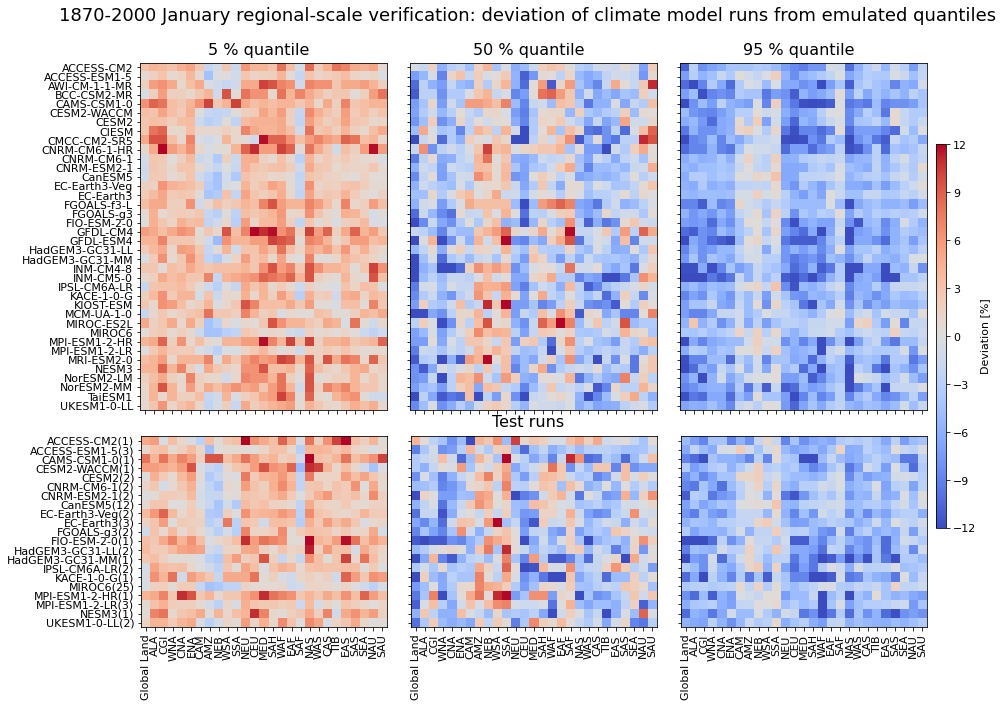

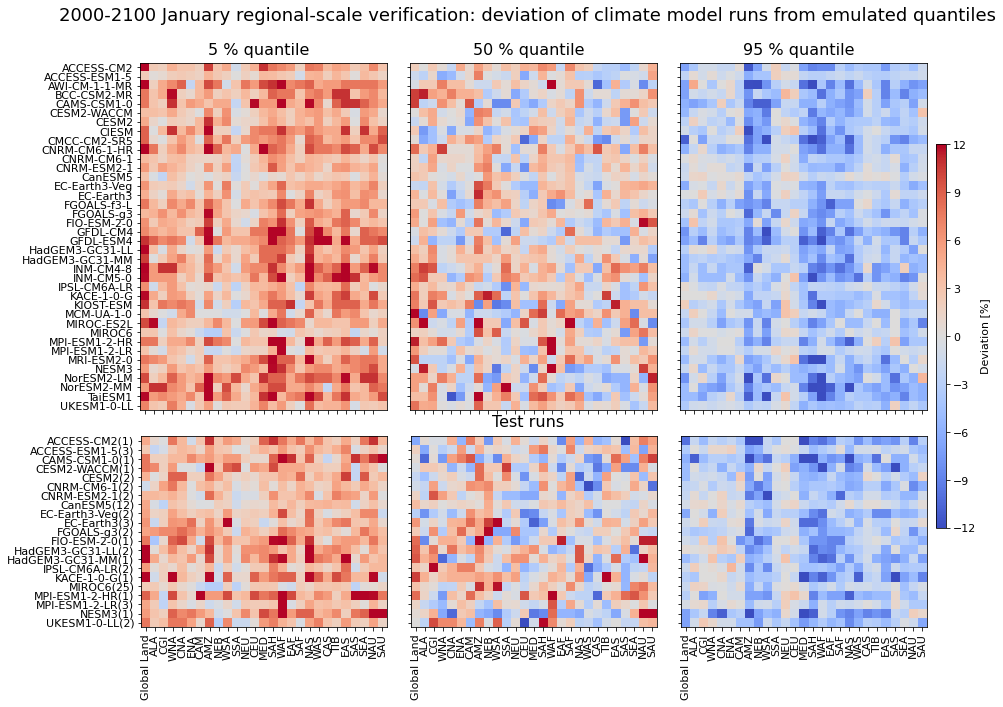

In [68]:
periods=['1870-2000','2000-2100']

for i_per in range(2):

    vmin = -12
    vmax = 12


    col_width=17
    row_width=9+9*12/40-1

    fs_title = 16


    plt.figure(figsize=(col_width, row_width ))
    plt.rcParams.update({'font.size': 11})
    plt.rcParams.update({'mathtext.default':'regular'}) 

    mask_te=np.asarray([i!=0 for i in test_label])
    grid = plt.GridSpec(40+12+15, 3, wspace=0.05, hspace=0) # create a grid for the subplots #0.12

    qs_sel=0.05
    axqs5=plt.subplot(grid[0,0])
    plt.text(x=0.5,y=0.5,s=str(5)+' % quantile',fontsize=fs_title,ha='center',va='center')
    plt.axis('off')

    axtr=plt.subplot(grid[1,:])
    plt.text(x=0.5,y=-0.3,s='Training runs',fontsize=fs_title,ha='center',va='top')
    plt.axis('off')

    ax1tr = plt.subplot(grid[2:42,0])
    mesh_qs=plt.imshow(arr_qs_tr_mod_regs[i_per][qs_sel][0,:,:],cmap='coolwarm',vmin=vmin,vmax=vmax)
    xk=plt.yticks(np.arange(len(models)),models)
    xk=plt.xticks(np.arange(len(all_regs)),all_regs,rotation=90)
    plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
    #for i in np.arange(len(models)):
    #    for j in np.arange(len(all_regs)+1): 
    #        if arr_viol_tr_mod_regs[i_per][qs_sel][0,i,j]!=0:
    #            plt.text(j,i,str(int(arr_viol_tr_mod_regs[i_per][qs_sel][0,i,j])),horizontalalignment='center',verticalalignment='center',color='grey',fontsize=7.5)

    axte=plt.subplot(grid[42,:])
    plt.text(x=0.5,y=-0.4,s='Test runs',fontsize=fs_title,ha='center',va='center')
    plt.axis('off')

    ax1te = plt.subplot(grid[45:,0])
    mesh_qs=plt.imshow(arr_qs_te_mod_regs[i_per][qs_sel][0,mask_te,:],cmap='coolwarm',vmin=vmin,vmax=vmax)
    xk=plt.yticks(np.arange(len(models_te)),models_names_te)
    xk=plt.xticks(np.arange(len(all_regs)+1),['Global Land']+all_regs,rotation=90)
    #for i in np.arange(len(models_te)):
    #    for j in np.arange(len(all_regs)+1): 
    #        if arr_viol_te_mod_regs[i_per][qs_sel][:,mask_te,:][0,i,j]!=0:
    #            plt.text(j,i,str(int(arr_viol_te_mod_regs[i_per][qs_sel][:,mask_te,:][0,i,j])),horizontalalignment='center',verticalalignment='center',color='grey', fontsize=7.5)


    qs_sel=0.5           
    axqs50=plt.subplot(grid[0,1])
    plt.text(x=0.5,y=0.5,s=str(50)+' % quantile',fontsize=fs_title,ha='center',va='center')
    plt.axis('off')

    ax2tr = plt.subplot(grid[2:42,1])
    mesh_qs=plt.imshow(arr_qs_tr_mod_regs[i_per][qs_sel][0,:,:],cmap='coolwarm',vmin=vmin,vmax=vmax)
    xk=plt.yticks(np.arange(len(models)),models)
    plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
    xk=plt.xticks(np.arange(len(all_regs)+1),['Global']+all_regs,rotation=90)
    plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
    #for i in np.arange(len(models)):
    #    for j in np.arange(len(all_regs)+1): 
    #        if arr_viol_tr_mod_regs[i_per][qs_sel][0,i,j]!=0:
    #            plt.text(j,i,str(int(arr_viol_tr_mod_regs[i_per][qs_sel][0,i,j])),horizontalalignment='center',verticalalignment='center',color='grey',fontsize=7.5)

    ax2te = plt.subplot(grid[45:,1])
    mesh_qs=plt.imshow(arr_qs_te_mod_regs[i_per][qs_sel][0,mask_te,:],cmap='coolwarm',vmin=vmin,vmax=vmax)
    xk=plt.yticks(np.arange(len(models_te)),models_te)
    plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
    xk=plt.xticks(np.arange(len(all_regs)+1),['Global Land']+all_regs,rotation=90)
    #for i in np.arange(len(models_te)):
    #    for j in np.arange(len(all_regs)+1):
    #        if arr_viol_te_mod_regs[i_per][qs_sel][:,mask_te,:][0,i,j]!=0:
    #            plt.text(j,i,str(int(arr_viol_te_mod_regs[i_per][qs_sel][:,mask_te,:][0,i,j])),horizontalalignment='center',verticalalignment='center',color='grey',fontsize=7.5)


    qs_sel=0.95
    axqs95=plt.subplot(grid[0,2])
    plt.text(x=0.5,y=0.5,s=str(95)+' % quantile',fontsize=fs_title,ha='center',va='center')
    plt.axis('off')            

    ax3tr = plt.subplot(grid[2:42,2])
    mesh_qs=plt.imshow(arr_qs_tr_mod_regs[i_per][qs_sel][0,:,:],cmap='coolwarm',vmin=vmin,vmax=vmax)
    xk=plt.yticks(np.arange(len(models)),models)
    plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
    xk=plt.xticks(np.arange(len(all_regs)+1),['Global Land']+all_regs,rotation=90)
    plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
    #for i in np.arange(len(models)):
    #    for j in np.arange(len(all_regs)+1): 
    #        if arr_viol_tr_mod_regs[i_per][qs_sel][0,i,j]!=0:
    #            plt.text(j,i,str(int(arr_viol_tr_mod_regs[i_per][qs_sel][0,i,j])),horizontalalignment='center',verticalalignment='center',color='grey',fontsize=7.5)

    ax3te = plt.subplot(grid[45:,2])
    mesh_qs=plt.imshow(arr_qs_te_mod_regs[i_per][qs_sel][0,mask_te,:],cmap='coolwarm',vmin=vmin,vmax=vmax)
    xk=plt.yticks(np.arange(len(models_te)),models_te)
    plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
    xk=plt.xticks(np.arange(len(all_regs)+1),['Global Land']+all_regs,rotation=90)
    #for i in np.arange(len(models_te)):
    #    for j in np.arange(len(all_regs)+1):
    #        if arr_viol_te_mod_regs[i_per][qs_sel][:,mask_te,:][0,i,j]!=0:
    #            plt.text(j,i,str(int(arr_viol_te_mod_regs[i_per][qs_sel][:,mask_te,:][0,i,j])),horizontalalignment='center',verticalalignment='center',color='grey',fontsize=7.5)

    cbar=plt.colorbar(mesh_qs,ax=[axtr,axte,ax1tr,ax1te,ax2tr,ax2te,ax3tr,ax3te,axqs5,axqs95,axqs50],shrink=0.66,pad=0.01,aspect=40)
    cbar.set_ticks(np.arange(-12,12.1,3))
    cbar.set_label('Deviation [%]')


    plt.suptitle(periods[i_per]+' January regional-scale verification: deviation of climate model runs from emulated quantiles',fontsize=fs_title+2,y=0.93,x=0.45)
    plt.savefig('/net/so4/landclim/snath/reg_veri_qd_jan_0%i.pdf'%i_per,dpi=300)

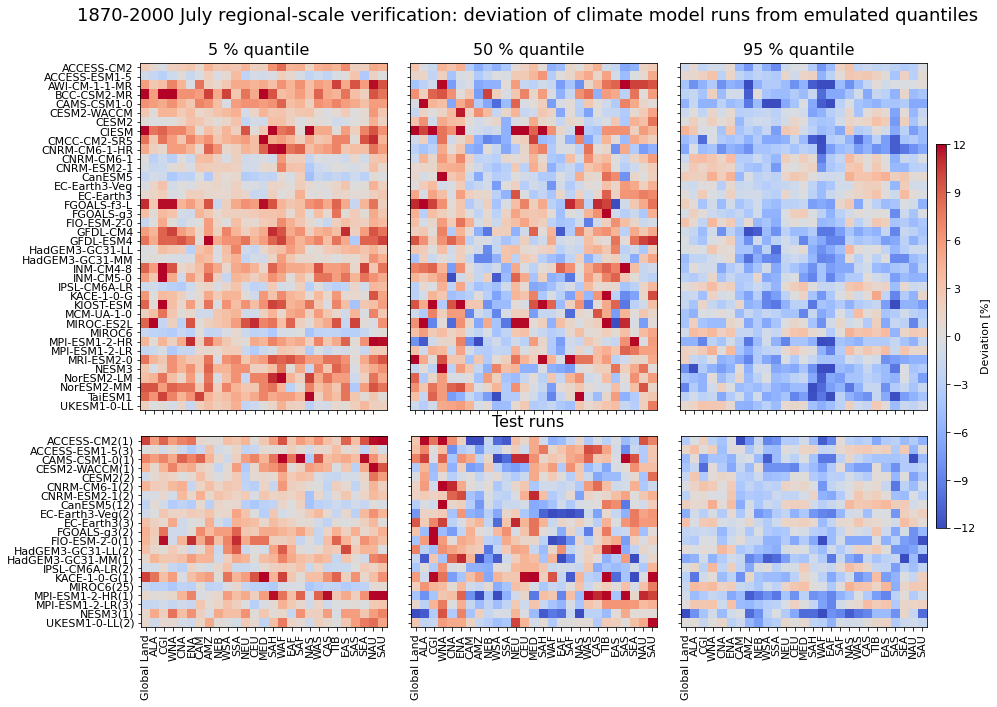

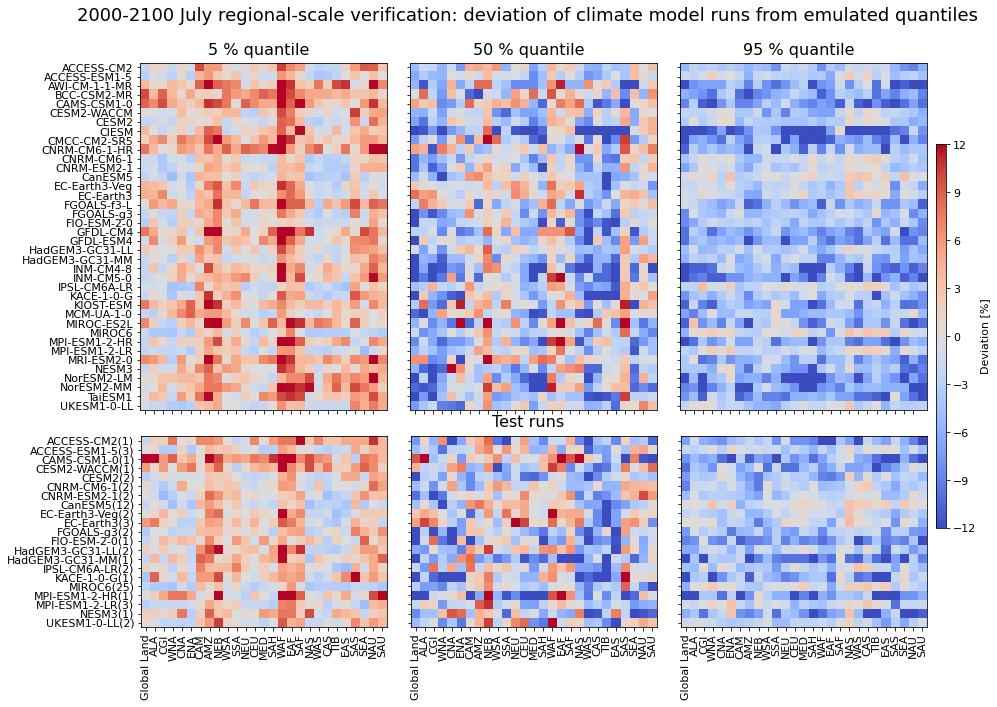

In [69]:
periods=['1870-2000','2000-2100']

for i_per in range(2):

    vmin = -12
    vmax = 12


    col_width=17
    row_width=9+9*12/40-1

    fs_title = 16


    plt.figure(figsize=(col_width, row_width ))
    plt.rcParams.update({'font.size': 11})
    plt.rcParams.update({'mathtext.default':'regular'}) 

    mask_te=np.asarray([i!=0 for i in test_label])
    grid = plt.GridSpec(40+12+15, 3, wspace=0.05, hspace=0) # create a grid for the subplots #0.12

    qs_sel=0.05
    axqs5=plt.subplot(grid[0,0])
    plt.text(x=0.5,y=0.5,s=str(5)+' % quantile',fontsize=fs_title,ha='center',va='center')
    plt.axis('off')

    axtr=plt.subplot(grid[1,:])
    plt.text(x=0.5,y=-0.3,s='Training runs',fontsize=fs_title,ha='center',va='top')
    plt.axis('off')

    ax1tr = plt.subplot(grid[2:42,0])
    mesh_qs=plt.imshow(arr_qs_tr_mod_regs[i_per][qs_sel][1,:,:],cmap='coolwarm',vmin=vmin,vmax=vmax)
    xk=plt.yticks(np.arange(len(models)),models)
    xk=plt.xticks(np.arange(len(all_regs)),all_regs,rotation=90)
    plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
    #for i in np.arange(len(models)):
    #    for j in np.arange(len(all_regs)+1): 
    #        if arr_viol_tr_mod_regs[i_per][qs_sel][1,i,j]!=0:
    #            plt.text(j,i,str(int(arr_viol_tr_mod_regs[i_per][qs_sel][1,i,j])),horizontalalignment='center',verticalalignment='center',color='grey',fontsize=7.5)

    axte=plt.subplot(grid[42,:])
    plt.text(x=0.5,y=-0.4,s='Test runs',fontsize=fs_title,ha='center',va='center')
    plt.axis('off')

    ax1te = plt.subplot(grid[45:,0])
    mesh_qs=plt.imshow(arr_qs_te_mod_regs[i_per][qs_sel][1,mask_te,:],cmap='coolwarm',vmin=vmin,vmax=vmax)
    xk=plt.yticks(np.arange(len(models_te)),models_names_te)
    xk=plt.xticks(np.arange(len(all_regs)+1),['Global Land']+all_regs,rotation=90)
    #for i in np.arange(len(models_te)):
    #    for j in np.arange(len(all_regs)+1): 
    #        if arr_viol_te_mod_regs[i_per][qs_sel][:,mask_te,:][1,i,j]!=0:
    #            plt.text(j,i,str(int(arr_viol_te_mod_regs[i_per][qs_sel][:,mask_te,:][1,i,j])),horizontalalignment='center',verticalalignment='center',color='grey',fontsize=7.5)


    qs_sel=0.5           
    axqs50=plt.subplot(grid[0,1])
    plt.text(x=0.5,y=0.5,s=str(50)+' % quantile',fontsize=fs_title,ha='center',va='center')
    plt.axis('off')

    ax2tr = plt.subplot(grid[2:42,1])
    mesh_qs=plt.imshow(arr_qs_tr_mod_regs[i_per][qs_sel][1,:,:],cmap='coolwarm',vmin=vmin,vmax=vmax)
    xk=plt.yticks(np.arange(len(models)),models)
    plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
    xk=plt.xticks(np.arange(len(all_regs)),all_regs,rotation=90)
    plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
    #for i in np.arange(len(models)):
    #    for j in np.arange(len(all_regs)+1): 
    #        if arr_viol_tr_mod_regs[i_per][qs_sel][1,i,j]!=0:
    #            plt.text(j,i,str(int(arr_viol_tr_mod_regs[i_per][qs_sel][1,i,j])),horizontalalignment='center',verticalalignment='center',color='grey',fontsize=7.5)

    ax2te = plt.subplot(grid[45:,1])
    mesh_qs=plt.imshow(arr_qs_te_mod_regs[i_per][qs_sel][1,mask_te,:],cmap='coolwarm',vmin=vmin,vmax=vmax)
    xk=plt.yticks(np.arange(len(models_te)),models_te)
    plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
    xk=plt.xticks(np.arange(len(all_regs)+1),['Global Land']+all_regs,rotation=90)
    #for i in np.arange(len(models_te)):
    #    for j in np.arange(len(all_regs)+1):
    #        if arr_viol_te_mod_regs[i_per][qs_sel][:,mask_te,:][1,i,j]!=0:
    #            plt.text(j,i,str(int(arr_viol_te_mod_regs[i_per][qs_sel][:,mask_te,:][1,i,j])),horizontalalignment='center',verticalalignment='center',color='grey',fontsize=7.5)


    qs_sel=0.95
    axqs95=plt.subplot(grid[0,2])
    plt.text(x=0.5,y=0.5,s=str(95)+' % quantile',fontsize=fs_title,ha='center',va='center')
    plt.axis('off')            

    ax3tr = plt.subplot(grid[2:42,2])
    mesh_qs=plt.imshow(arr_qs_tr_mod_regs[i_per][qs_sel][1,:,:],cmap='coolwarm',vmin=vmin,vmax=vmax)
    xk=plt.yticks(np.arange(len(models)),models)
    plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
    xk=plt.xticks(np.arange(len(all_regs)),all_regs,rotation=90)
    plt.gca().xaxis.set_major_formatter(plt.NullFormatter())
    #for i in np.arange(len(models)):
    #    for j in np.arange(len(all_regs)+1): 
    #        if arr_viol_tr_mod_regs[i_per][qs_sel][1,i,j]!=0:
    #            plt.text(j,i,str(int(arr_viol_tr_mod_regs[i_per][qs_sel][1,i,j])),horizontalalignment='center',verticalalignment='center',color='grey',fontsize=7.5)

    ax3te = plt.subplot(grid[45:,2])
    mesh_qs=plt.imshow(arr_qs_te_mod_regs[i_per][qs_sel][1,mask_te,:],cmap='coolwarm',vmin=vmin,vmax=vmax)
    xk=plt.yticks(np.arange(len(models_te)),models_te)
    plt.gca().yaxis.set_major_formatter(plt.NullFormatter())
    xk=plt.xticks(np.arange(len(all_regs)+1),['Global Land']+all_regs,rotation=90)
    #for i in np.arange(len(models_te)):
    #    for j in np.arange(len(all_regs)+1):
    #        if arr_viol_te_mod_regs[i_per][qs_sel][:,mask_te,:][1,i,j]!=0:
    #            plt.text(j,i,str(int(arr_viol_te_mod_regs[i_per][qs_sel][:,mask_te,:][1,i,j])),horizontalalignment='center',verticalalignment='center',color='grey',fontsize=7.5)

    cbar=plt.colorbar(mesh_qs,ax=[axtr,axte,ax1tr,ax1te,ax2tr,ax2te,ax3tr,ax3te,axqs5,axqs95,axqs50],shrink=0.66,pad=0.01,aspect=40)
    cbar.set_ticks(np.arange(-12,12.1,3))
    cbar.set_label('Deviation [%]')


    plt.suptitle(periods[i_per]+' July regional-scale verification: deviation of climate model runs from emulated quantiles',fontsize=fs_title+2,y=0.93,x=0.45)
    plt.savefig('/net/so4/landclim/snath/reg_veri_qd_jul_0%i.pdf'%i_per,dpi=300)